In [2]:
import numpy as np 
import matplotlib.pyplot as plt


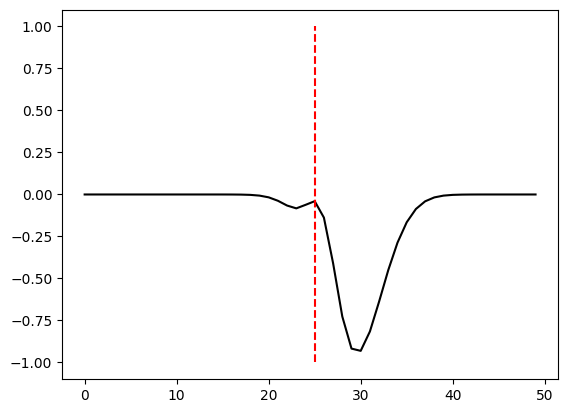

In [ ]:
num_trials = 100
x = np.arange(50)

positive_gaussian = 0.5 * np.exp(-(x - 26)**2 / 5)
negative_gaussian = -1  * np.exp(-(x - 29)**2 / 20)
combined_gaussian = positive_gaussian + negative_gaussian

# plt.plot(x, positive_gaussian, label='Positive Gaussian', color='steelblue')
# plt.plot(x, negative_gaussian, label='Negative Gaussian', color='yellow')
plt.plot(x, combined_gaussian, label='Combined Gaussian', color='k')
plt.vlines(x=25, ymin=-1, ymax=1, color='r', linestyle='--')

# Repeat  the plot for 100 times

a = np.tile(combined_gaussian, (num_trials, 1))

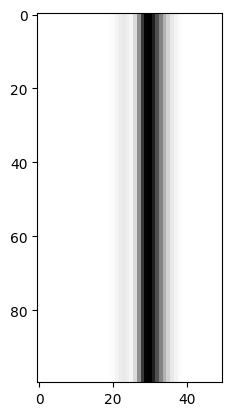

In [ ]:
# a = np.repeat(combined_gaussian, num_trials)
a = np.tile(combined_gaussian, (num_trials, 1))
w = -0.1
vel_pred = w * real_velocity
noise = np.random.normal(0, 1, a.shape)
a = a + vel_pred + noise
plt.imshow(a, cmap='gray')